# Generating ROC Curves

In this notebook, we'll depict how ROC curves can be generated for our power cut approach.

First we're importing some modules, defining some values and functions to generate our probability density functions. 

In [2]:
import sys
sys.path.append("../")

from __init__ import *
from data_tools import *
from testing import *
from analysis import *

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

R, Nch, kb, bw, Nsamp, T= 496.1709043911709, 1, 1.38e-23, 1000e6, 40960, 5

n_pwr = kb * T * bw # noise power
tau_1t = n_pwr * R # noise variance single channel, time-domain (tau_1t)
tau_1f = tau_1t / Nsamp # noise variance single channel, freq-domain (tau_1f)

# Generate example distributions
def calculate_signal_dists(vals, tau, loc, FFT_peaks, Nsamp):

    rice_cdf = np.ones(len(vals))
    for peak in FFT_peaks:
        rice_cdf *= scipy.stats.rice.cdf(vals, b=abs(peak)/np.sqrt(tau/2), loc=loc, scale=np.sqrt(tau/2))
            
    cdf = rice_cdf * (1-np.exp(-(vals**2)/tau)) ** (Nsamp-FFT_peaks.size)

    pdf = np.gradient(cdf, vals[1]-vals[0])
    
    return cdf, pdf
    
def calculate_noise_dists(vals, tau, Nsamp):
    ray_cdf = (1-np.exp(-(vals**2)/tau)) ** Nsamp
    ray_pdf = np.gradient(ray_cdf, vals[1]-vals[0])
    
    return ray_cdf, ray_pdf



The next code cell takes all of this and generates the ROC curves for the different power cut thresholds.

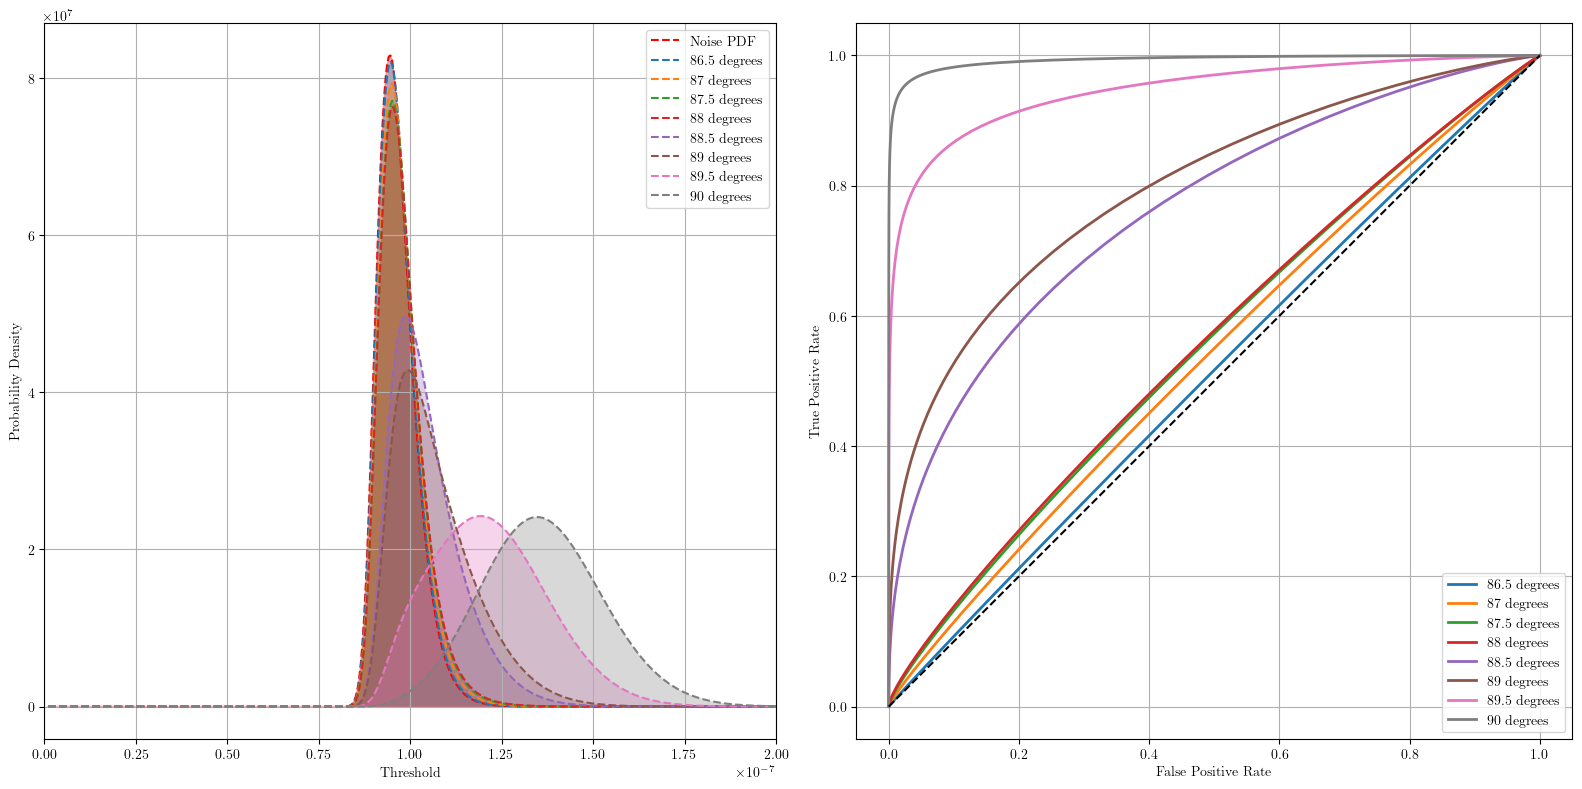

In [ ]:
from scipy import stats

threshold = np.linspace(1e-9, 9e-6, 20001)
x = threshold

noise_pdf = calculate_noise_dists(threshold, tau_1f, Nsamp)[1]
# signal_pdf = calculate_signal_dists(threshold, tau_1f, 0, peaks, Nsamp)[1]
# signal86p5 = calculate_signal_dists(threshold, tau_1f, 0, peaks1, Nsamp)[1]

# Calculate CDFs
noise_cdf = calculate_noise_dists(threshold, tau_1f, Nsamp)[0]
# signal_cdf = calculate_signal_dists(threshold, tau_1f, 0, peaks, Nsamp)[0]
# signal_cdf86p5 = calculate_signal_dists(threshold, tau_1f, 0, peaks1, Nsamp)[0]

# Calculate ROC points (FPR = 1-specificity, TPR = sensitivity)
fpr = 1 - noise_cdf  # false positive rate


file_list = [
    'harmonic/86p5deg/out_0aa72c89-416e-4f11-8eda-ae7542078817.h5', 
    'harmonic/87deg/out_0a5c4e19-2fc3-4f5c-9090-8d2cce62ae19.h5', 
    'harmonic/87p5deg/out_0c7fdf39-0ea3-4c84-9a9d-60c68b480bb1.h5', 
    'harmonic/88deg/out_0ad74f8f-ec02-44f5-a5af-5c69bef4774e.h5',
    'harmonic/88p5deg/out_0a1bc7f8-6e25-47f3-9743-f404227c3d0b.h5',
    'harmonic/89deg/out_1a0ad631-1153-47ef-8cba-ea9ab0cefa3d.h5',
    'harmonic/89p5deg/out_51db499d-c8ea-4cce-884b-d9c3e3f44ed1.h5',
    'harmonic/90deg/out_0a5a3368-a72b-4392-9ccd-bbcaf9762cbd.h5']

harmonic_angles = ['86.5', '87', '87.5', '88', '88.5', '89','89.5', '90']

# Plot distributions and ROC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot PDFs
ax1.plot(threshold, noise_pdf, 'r--', label='Noise PDF')
ax1.fill_between(threshold, noise_pdf, alpha=0.3, color='red')

aucs = []

for i, file_name in enumerate(file_list):

    # signal_strings, attributes, attrs_container = get_attributes(file_name)
    signal = get_signal(file_name, 'signal1') # One polarisation
    signal_FFT = np.fft.fft(signal, norm='forward')

    # signal_maximums = signal_FFT[signal_FFT > 1e-8]
    # peaks = np.array(signal_maximums)
    
    # print(peaks)
    
    # signal_max_index = np.argmax(abs(signal_FFT))
    # complex_signal_max = signal_FFT[signal_max_index]

    pks = get_signal_peaks(signal, 1e-8)
    
    # print(peaks)

    rice_cdf = np.ones(20001)
    for peak in pks:
        rice_cdf *= scipy.stats.rice.cdf(x, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
        
    signal_cdf = rice_cdf * (1-np.exp(-(x**2)/tau_1f)) ** (Nsamp-pks.size)

    signal_pdf = np.gradient(signal_cdf, x[1]-x[0])


    tpr = 1 - signal_cdf  # true positive rate

    signal_label = str(harmonic_angles[i]) + ' degrees'
    
    ax1.plot(threshold, signal_pdf, '--', label=signal_label)
    ax1.fill_between(threshold, signal_pdf, alpha=0.3)
    # Plot ROC curve
    
    roc_label = str(harmonic_angles[i]) + ' degrees'
    
    ax2.plot(fpr, tpr, '-', linewidth=2, label=roc_label) 
    auc = abs(np.trapz(tpr, fpr))
    aucs.append(auc)


ax1.set_xlabel('Threshold')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.set_xlim(0, 0.2e-6)
ax1.grid(True)


ax2.plot([0, 1], [0, 1], 'k--')  # random guess line
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.grid(True)
ax2.set_aspect('equal')
ax2.legend()

plt.tight_layout()
plt.savefig('harmonic_roc.png')
plt.show()

# Delete the two code cells below.

/var/folders/cl/l2qg34px6s96_4z813158xdh0000gn/T/ipykernel_23323/1865865277.py:189: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


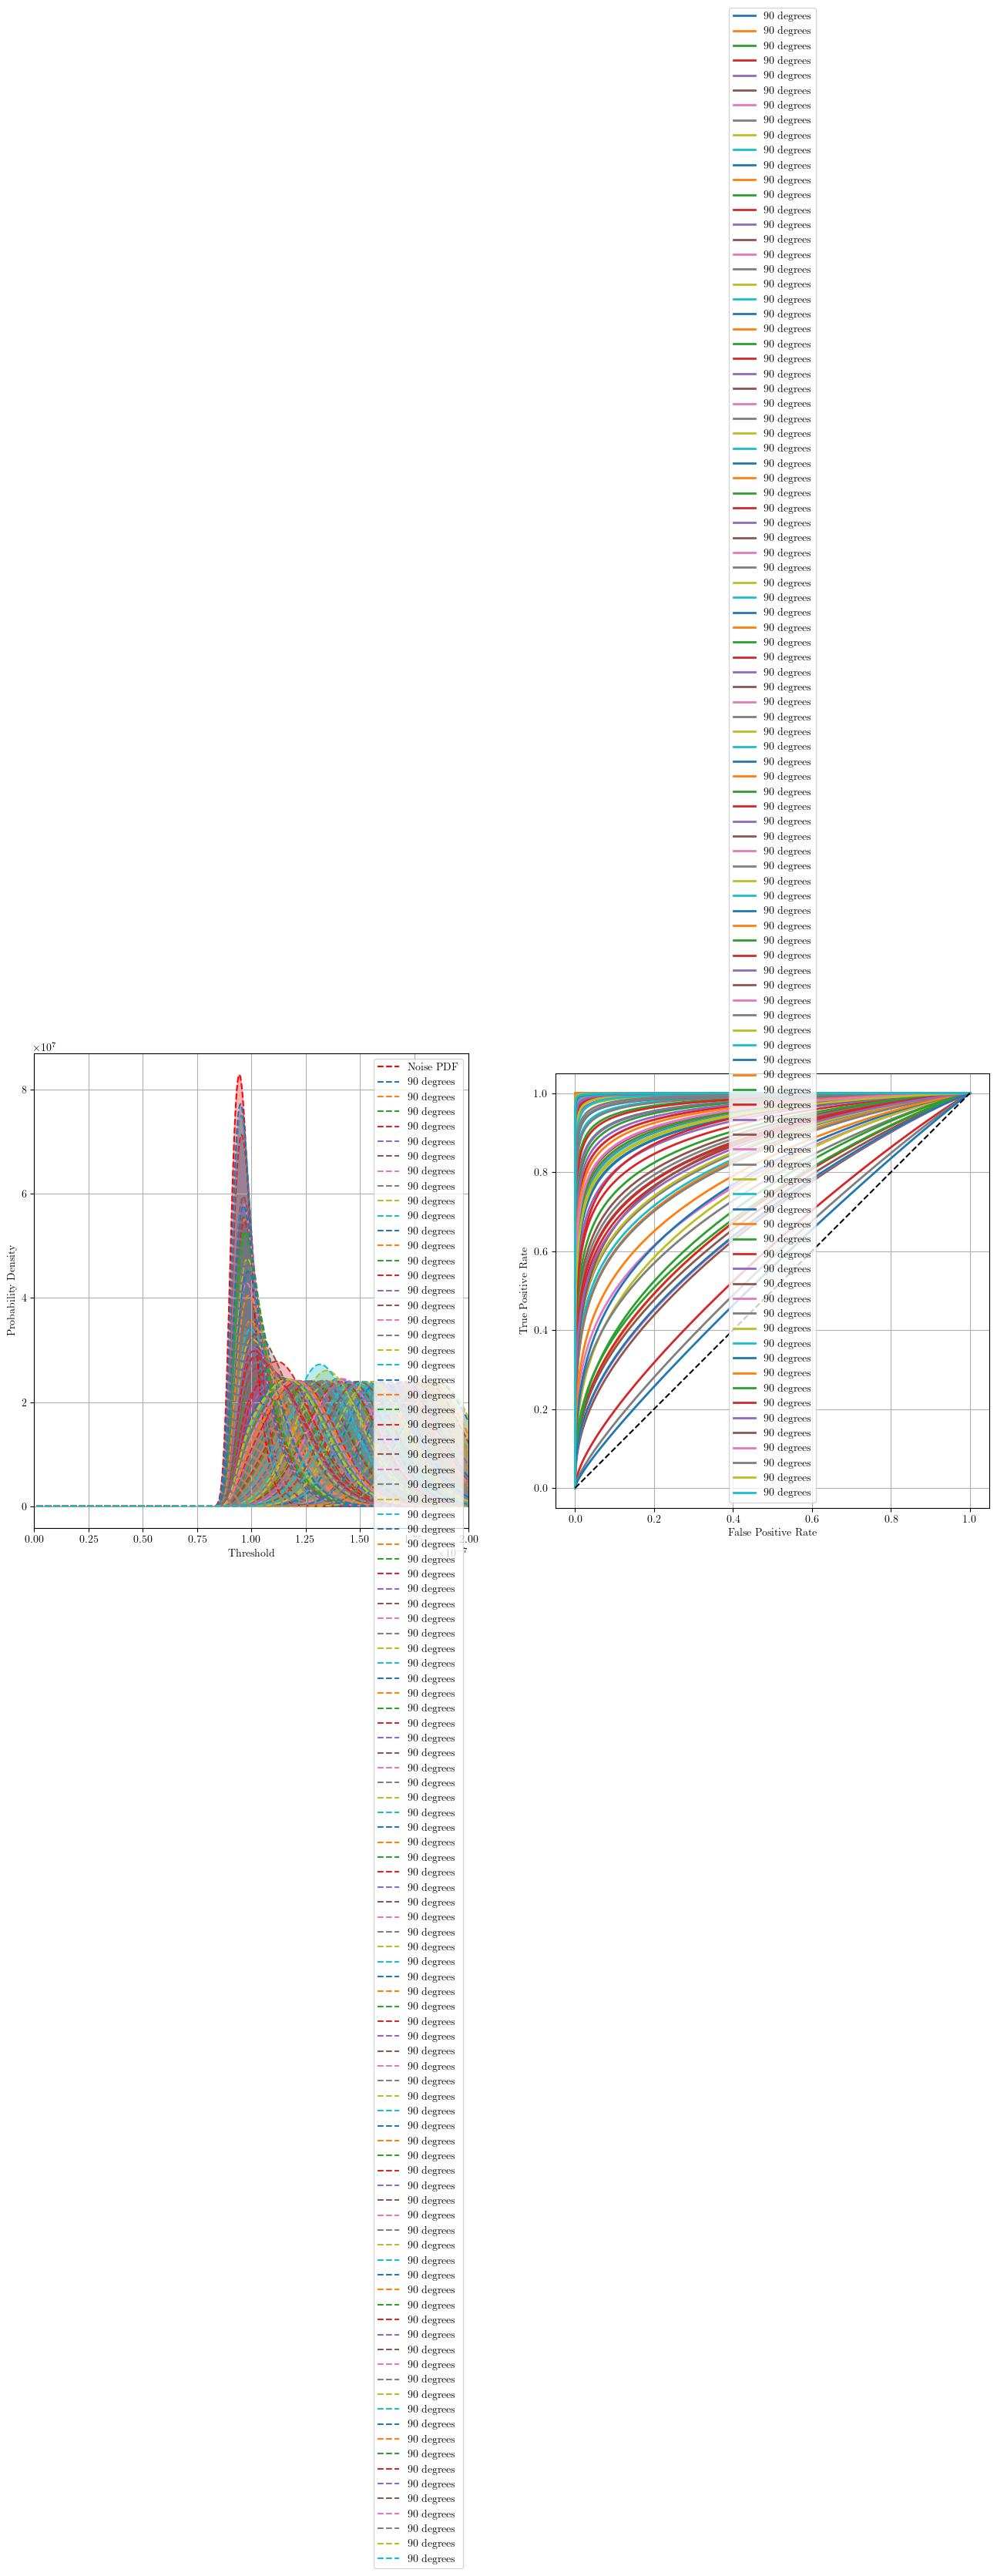

In [9]:
from scipy import stats

threshold = np.linspace(1e-9, 9e-6, 20001)
x = threshold

noise_pdf = calculate_noise_dists(threshold, tau_1f, Nsamp)[1]
# signal_pdf = calculate_signal_dists(threshold, tau_1f, 0, peaks, Nsamp)[1]
# signal86p5 = calculate_signal_dists(threshold, tau_1f, 0, peaks1, Nsamp)[1]

# Calculate CDFs
noise_cdf = calculate_noise_dists(threshold, tau_1f, Nsamp)[0]
# signal_cdf = calculate_signal_dists(threshold, tau_1f, 0, peaks, Nsamp)[0]
# signal_cdf86p5 = calculate_signal_dists(threshold, tau_1f, 0, peaks1, Nsamp)[0]

# Calculate ROC points (FPR = 1-specificity, TPR = sensitivity)
fpr = 1 - noise_cdf  # false positive rate


file_list = ['../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_584846aa-0534-4f7c-89c8-1ae50fb55d72.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_7dcc5b09-78eb-4ccb-8d1b-f5f713df3c13.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_52a68427-8d6d-41fe-b66e-33594ca69df9.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_c26f4e66-a29c-4290-a099-cbfb31c20154.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_29c0ca2d-06b8-44fe-a4f6-f88c9836fe3c.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_38ae726c-67f7-45db-a1f1-4b5615f36644.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_c0175975-fb54-40e1-aa54-58942b6b88d0.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_e4bddee7-0f16-4150-ac29-20f9244c3f91.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_07e998f7-39d3-43c9-a759-27da2e5d2aff.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_c97d0777-2112-4637-b6ca-5e86e7b6ea01.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_14bf69e7-02fe-4546-a71f-93a7daa321f9.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_1de2cacc-90a7-4a37-a5ea-afcf534960ab.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_413cbb47-36d4-4cbd-a667-43af17beec1f.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_f5a2c5d3-1732-4596-86a6-6d8bc22268ca.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_2afba109-ee44-4252-a2d1-6cb21ae18e73.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_898ea858-a61f-4834-842d-ec004bb59954.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_eb81e461-9341-4c10-b43a-6c799ddaee08.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_1819df64-0aca-41a5-98e3-13db457c4820.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_1e4dcd96-aee1-45cb-8789-f3ffc96fe41a.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_50599067-5b6f-4c02-b2da-035bf4326734.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_7f4d0563-094c-4aca-a448-56d39f6ff477.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_96323e75-042a-45a0-a257-55e6606a5ad3.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_faa62203-94a7-4f53-9279-81f0ca14ee2f.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_2b5ecbed-d6c3-420f-b214-6eec15f589d8.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_1228e611-7b71-4ec6-8a74-c5e0d243486b.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_f008810e-fadf-40a7-b0f1-5a2024c9df6f.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_77a486cb-ae7f-412f-903c-9ccbc6456847.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_38d86e58-99ee-4907-b60e-bec11345fd70.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_920d72a1-59b7-417f-a6a3-6dd6762708f9.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_8f5910a2-d016-4506-b099-65825812e211.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_e7d9e92b-0a5b-4cc6-be13-e4774b1ca05b.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_cfe28d37-8034-4db1-849e-62946a669479.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_b2025ee6-6390-4222-8f7c-a03279f99296.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_4d77c33d-b527-4ce7-bd74-c07acbfba78e.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_145618b1-295a-4b51-ac73-3c935169c448.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_0d30b2c4-a090-4094-8760-7137a54f3b2d.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_a8413de9-2525-4d90-a4ac-820bc918dc51.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_386ed1c3-c10b-4455-bf36-e1d6fa38eef1.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_5e751ee0-5866-44d5-85b4-ab3dc683a259.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_729041b1-e577-4def-b3e2-9b157250b7ee.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_5b9628b5-ebcb-4548-8bf0-303c1b8a238c.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_e62183db-519a-4d32-93aa-0fb51a4f881e.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_2674cb38-2120-497a-88a4-2d1d56d0709a.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_71fa179f-48a1-483a-9994-dc9f8274fc3f.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_1b0cff19-903b-43fc-b60e-7016eb3848ec.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_851d5cdc-0da1-4b95-8284-ac2ed86bbc03.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_2cbaf0ec-54d7-4f94-9442-e654bd01a261.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_cf356d41-f9b3-49f9-a3af-49579f53156f.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_876e0e68-f432-4482-9e8a-d74c2a09967e.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_064a2971-f6ef-43dc-a4d5-5612dd4762bf.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_58b19f92-a8c7-476c-9605-cbb0e8a3b8f4.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_8ff22f9c-c11a-413c-84ec-2f1f80b0daa4.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_e4021d2a-3993-450b-83fb-5d69a2f7a9c1.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_7c9188bc-2bed-49e9-942b-c84962251ac3.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_24c52b49-38b2-4c9e-9cdb-64cbb5ee33b8.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_8c33b050-cb55-43f5-b33b-b1eb6d1acaab.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_20d161ed-c357-4100-9a1c-efee2fec38eb.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_70de0c10-b5d5-4fa3-a892-cb297cc135ae.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_10e67008-9e65-4c45-8a5d-5e878d0a0306.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_57347ae1-7bff-4e4c-96b4-0d3603eb196b.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_83df25e0-4606-43e2-b148-aa9f63d10a9e.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_d6b4f1c5-0038-458c-8f5f-c5d8dd8088e6.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_2ea274c3-e5c5-4620-b97c-c653ddbc438b.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_40d31f65-9dfc-49c1-a177-3f4d25daaf53.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_c8dee21e-e81f-4d32-b24f-d3859f6145b6.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_661aee5a-7379-483e-8d8d-838ad438e14a.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_0e084422-dc49-4a76-ab4b-5b3641c0fb6c.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_26e61dcc-9901-424c-87da-c80a6562746c.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_1b5a58a0-e0ee-41e7-a2f1-7d83f09a18ac.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_7b21073b-8d0e-4f85-bda2-73460b2e1773.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_473cf56f-c917-403b-b1e2-966ad40c1ae5.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_b7cfb5a3-9f9b-405a-aada-e2b230721da2.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_802c9ce0-0686-460b-895e-a170c463a14c.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_56ff9068-36b7-4822-bfcd-e497ec71d0d5.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_5370e3cc-483a-4514-9756-1b0c4a74bf6a.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_b225df28-640b-412e-b9f7-e8fb723e8c9e.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_5a81072e-5271-45c5-b0a7-f275a5be3a42.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_6e7de0b7-4e7b-4a29-ac77-270b10f735d4.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_b2a37f33-0241-4316-96cd-ed576dc9f1bb.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_201e9175-5237-49aa-8265-78fa7d88e2a9.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_f31f674c-e160-445d-93ec-6d0448a860eb.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_5ce2ff74-43cd-413d-b250-581a0a830ba5.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_95d33cba-1fbc-42d2-a3c4-85bc2d14a9b0.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_ca0c7d1a-37b3-4fd3-b178-311e65b8bb72.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_33cbc249-0750-4d54-80f5-d6ccdc70e3f8.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_9fa12816-7e72-495b-93fc-5cbc555ab997.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_77d1c418-2be7-4fc0-b00a-a13bb0a3af72.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_eea6f54d-fee8-4118-a562-8b2f68ba6b1d.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_4d445cdf-5c0f-408c-9628-d43ee71701fc.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_ba372efa-5f85-4817-87b3-2a9acec488d5.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_7d3b9e0e-3c5c-45c1-a564-4883a07a9d29.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_f7bd79a3-aa71-4f3b-918d-643f562c4abc.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_5c8681a2-5b97-4101-9879-f818a9c41d5f.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_a6389af4-2d85-44ec-ac45-79d077511ee2.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_7bb63f93-95e2-415a-977c-c0e65a4fcfe8.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_49353bb5-b497-4c3e-9d33-6b3f77e36a7d.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_1dcea9b0-a111-45db-a0a6-ef78f7347fd3.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_30d0d36b-8a5d-43b4-8a45-5c464f455787.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_02900450-2747-490c-9217-b1a7bb64d78a.h5',
'../../../../Desktop/1Tesla/v1/Harmonic/90.0deg/out_b97792e5-2341-497c-a0ea-8adfb1ab6405.h5']

# harmonic_angles = ['86.5', '87', '87.5', '88', '88.5', '89','89.5', '90']

harmonic_angles = ['90']*len(file_list)

# Plot distributions and ROC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot PDFs
ax1.plot(threshold, noise_pdf, 'r--', label='Noise PDF')
ax1.fill_between(threshold, noise_pdf, alpha=0.3, color='red')

aucs = []

for i, file_name in enumerate(file_list):

    # signal_strings, attributes, attrs_container = get_attributes(file_name)
    signal = get_signal(file_name, 'signal1') # One polarisation
    signal_FFT = np.fft.fft(signal, norm='forward')

    # signal_maximums = signal_FFT[signal_FFT > 1e-8]
    # peaks = np.array(signal_maximums)
    
    # print(peaks)
    
    # signal_max_index = np.argmax(abs(signal_FFT))
    # complex_signal_max = signal_FFT[signal_max_index]

    pks = get_signal_peaks(signal, 1e-8)
    
    # print(peaks)

    rice_cdf = np.ones(20001)
    for peak in pks:
        rice_cdf *= scipy.stats.rice.cdf(x, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
        
    signal_cdf = rice_cdf * (1-np.exp(-(x**2)/tau_1f)) ** (Nsamp-pks.size)

    signal_pdf = np.gradient(signal_cdf, x[1]-x[0])


    tpr = 1 - signal_cdf  # true positive rate

    signal_label = str(harmonic_angles[i]) + ' degrees'
    
    ax1.plot(threshold, signal_pdf, '--', label=signal_label)
    ax1.fill_between(threshold, signal_pdf, alpha=0.3)
    # Plot ROC curve
    
    roc_label = str(harmonic_angles[i]) + ' degrees'
    
    ax2.plot(fpr, tpr, '-', linewidth=2, label=roc_label) 
    auc = abs(np.trapz(tpr, fpr))
    aucs.append(auc)


ax1.set_xlabel('Threshold')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.set_xlim(0, 0.2e-6)
ax1.grid(True)


ax2.plot([0, 1], [0, 1], 'k--')  # random guess line
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.grid(True)
ax2.set_aspect('equal')
ax2.legend()

plt.tight_layout()
plt.savefig('harmonic_roc.png')
plt.show()

/var/folders/cl/l2qg34px6s96_4z813158xdh0000gn/T/ipykernel_23323/3245491550.py:190: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


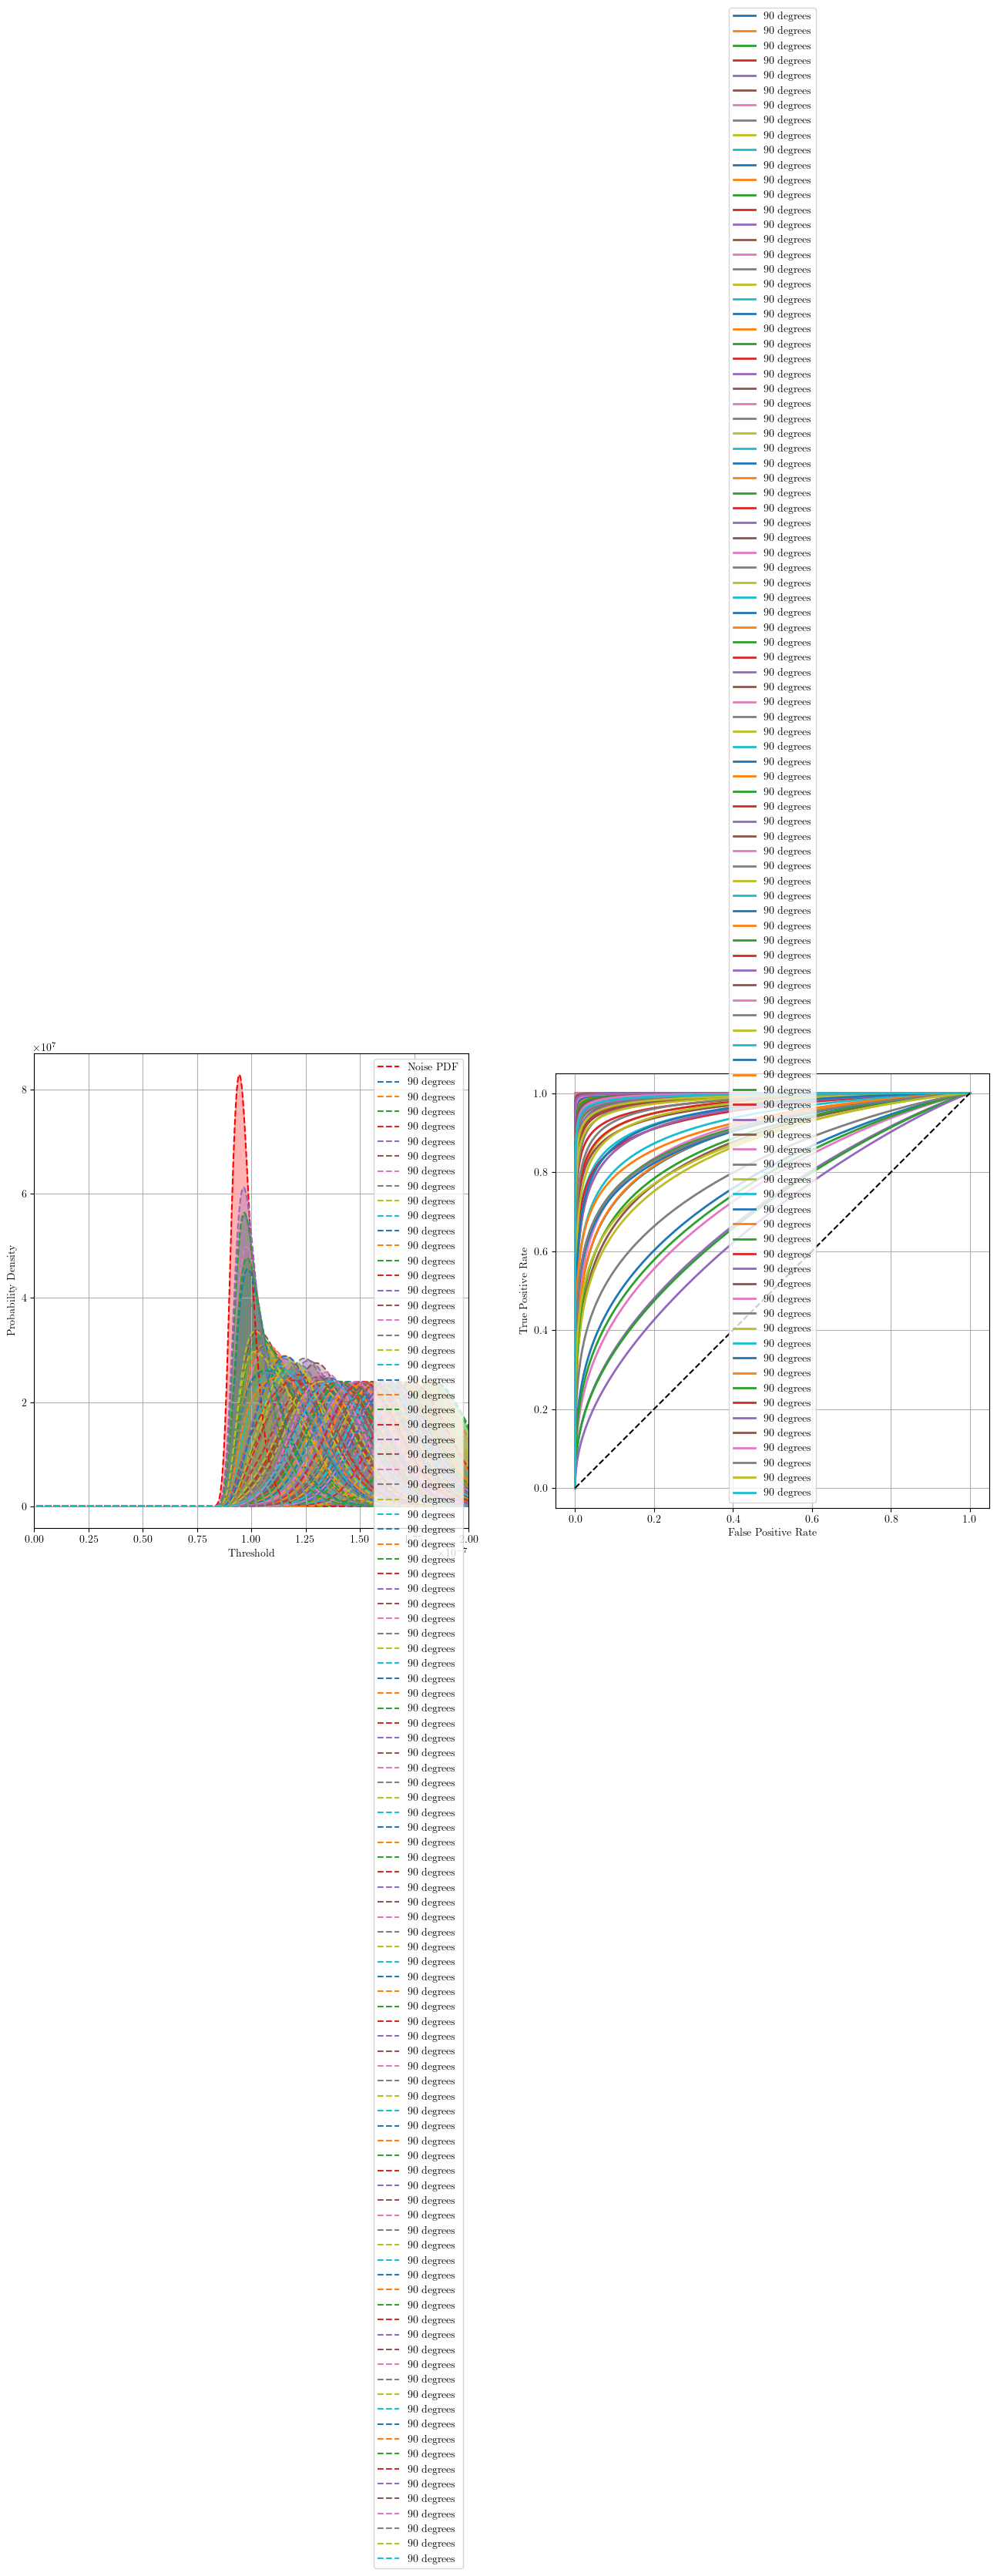

In [10]:
from scipy import stats

threshold = np.linspace(1e-9, 9e-6, 20001)
x = threshold

noise_pdf = calculate_noise_dists(threshold, tau_1f, Nsamp)[1]
# signal_pdf = calculate_signal_dists(threshold, tau_1f, 0, peaks, Nsamp)[1]
# signal86p5 = calculate_signal_dists(threshold, tau_1f, 0, peaks1, Nsamp)[1]

# Calculate CDFs
noise_cdf = calculate_noise_dists(threshold, tau_1f, Nsamp)[0]
# signal_cdf = calculate_signal_dists(threshold, tau_1f, 0, peaks, Nsamp)[0]
# signal_cdf86p5 = calculate_signal_dists(threshold, tau_1f, 0, peaks1, Nsamp)[0]

# Calculate ROC points (FPR = 1-specificity, TPR = sensitivity)
fpr = 1 - noise_cdf  # false positive rate


file_list = [
'../../../../Desktop/v2/Harmonic/90.0deg/out_4976c7bd-743b-49a2-99e4-3f13129d44f6.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_7e6aa318-da4b-44df-9c7a-1d3aa145ec95.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_0f1b9486-39d3-4506-9d25-26124797daaa.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_2b704f91-eef3-40eb-b3f7-66018ec408f5.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_97f6e7b8-4717-4e22-ad4c-4a36756fd2c2.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_7aa3c359-e65f-4d3b-ac30-8939462c00a9.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_31cae1d9-c62c-403d-93f0-2e2a81c79948.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_fccfefa1-82b4-4bf2-9e75-0a792badcf32.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_9da4ab31-7923-4dd5-ac10-43fc72270166.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_c61fe326-c0c5-40fb-bf91-788e3e80c458.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_2e1fad5f-7d9b-4757-a091-7d663bb39524.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_64f1d04b-5c61-43d0-a607-f72ccb2e73a2.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_c16e4ef7-898d-4009-9c90-4a1e1a5fc9ae.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_4367ae67-ba83-4078-8355-7723e6e4821f.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_b469c180-2cd1-4b37-a54a-be83169943ae.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_c480765c-e305-41ea-aed6-d538b7e690aa.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_3e5ebbd2-24dd-4f9c-90a9-3ba3c702d90d.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_824ed15d-adc1-4f40-8943-d1311f5ba7c6.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_87cd4a49-7c12-445b-b011-7187c11b9ee2.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_bce80511-e97f-4d3d-bf99-f8b6ea167bd4.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_c766371f-ad7d-4a62-addd-be6e40c2a243.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_e972e1bc-9ac3-4eed-b55f-1c35fee82ac9.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_910fe731-5fc4-4e94-9bc2-c393f923c3f0.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_e15ae87e-e64f-418b-9020-87f4736859d5.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_253c37b8-5eec-4b31-8941-f9dfe65b66b9.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_ba989b18-bffb-4d10-8d35-1926056f591c.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_a3140f60-9be3-498c-94a2-b764dbde8319.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_00f44594-6adf-4caf-84de-6332610be600.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_efc50672-ca98-4b66-aa88-45e739fe79c6.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_36273bb0-9fc4-4da4-b55a-fc1f10d0a337.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_44635470-41c6-447d-9942-5acd31adc379.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_59a76ef7-c006-4183-8eac-ab566f96a2f1.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_c6e4a978-e271-40e2-81bd-f536f89e9a9c.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_95df0dbf-a699-412f-9454-f8fc485b9024.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_19977e8d-ae73-4700-a03f-0de6bd2cc89f.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_e12f6407-8832-48c6-88f3-65c1ae8bfb12.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_b05965cb-7182-4e9b-83b0-bfa331054eba.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_769d36b2-799d-4fc7-81a6-1be603f249f8.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_01a8030e-acff-4668-8b46-67867bd1814f.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_248b3cd5-f36e-4a61-8ae2-c992f39edb8a.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_03e7dbcb-ce57-4203-b077-5494bc465bae.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_2b20d0da-78d1-40c1-9e33-7dbe5790a786.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_1e6fcd43-01fc-44fe-92a8-979e1e9270e8.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_dd97cee0-89dc-4ca3-a1e5-63718c3d90e1.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_8e178af9-fd43-459e-971a-947633956ae8.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_d031acb9-2947-4b03-9f5b-30f70d48c272.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_52606c3f-200b-4323-936d-67a4caa0e46a.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_066f6056-9088-4d62-b400-0e7fe41c2347.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_343dc873-bc13-4375-8d88-f2129cde0fd6.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_1b281597-d5b7-437b-a962-d83840dbd1c3.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_ef4b5ef2-ff7b-436c-9b85-6bfbd1625cb9.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_908b0f71-7f23-473d-bbe1-b902d186cfab.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_1024c43d-0726-40c6-8b59-2e104179f890.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_65bf1bb3-c20e-4154-b1be-eb4ff047ef2a.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_20672790-50e0-4caf-9b8a-4d7a8ecec689.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_a1992805-291e-47af-aee9-bf78bf4e82f4.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_2e1cf92a-28b9-42a7-8a6d-908877350029.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_2ec4d533-d57b-47f6-aae1-4b9a71b70add.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_7c83e67d-f2d8-46a9-8750-bd8106d5f793.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_038a1490-acb4-491b-b7b0-0b34a11efae5.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_0b304bfe-52e5-433a-aca6-eecceb062e3d.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_7aaaf9b9-6359-483a-a667-cff400d8818a.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_a25d5b5c-27ca-4f0b-b87b-a6df3d60e921.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_db4d4df5-8ad7-4b56-b582-d4205c815d9f.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_817d3695-b121-4d9a-9298-7dbb3aa08f00.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_623bc6eb-a17c-436c-8788-cddbf2b51f15.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_0a5a3368-a72b-4392-9ccd-bbcaf9762cbd.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_7d859207-6c74-4136-97c1-bb24ce27314e.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_b572bae6-be18-4b0d-b435-53fa5a18a504.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_ed4c05ba-53aa-4a5f-8acc-0509cd4b5c33.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_3a22b1be-71ac-4be2-982f-fc7284e63af7.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_62bea76b-f0e7-4665-aece-3a526b75af86.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_6af1ca6d-429d-4d40-a516-a6576447a9f3.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_db8ba722-e7fc-4c01-a946-6614dc7c7f3a.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_81bd2326-0f4c-4b5e-a5a3-0a726dda9164.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_38e6c2b1-f9c7-42b7-aa41-6356f0dc584b.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_bf3e06a8-fc30-480c-ade8-514613d91a7b.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_08070d92-7fea-406e-9113-f426d7b090f9.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_54efc53b-5e2b-4e15-97b9-1d37f7ba3b2f.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_aaa77266-bb87-4818-94db-ffed45934bf5.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_45dbdb0d-96cc-49ba-86e5-6f10c0a0ef93.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_23be6e49-7cc3-4a30-9be6-3981288718da.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_72298236-d401-446c-b9a9-57e3d0499600.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_b5a849d1-d916-462d-8f63-3e961ff2ad36.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_f6545dca-6fec-4731-9910-9a399fdfa0b7.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_836b833e-e006-42ba-8b84-dacec198c5f8.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_9222faeb-7fa5-44bb-86fb-70cf4e24c6f3.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_cfd13204-dbe2-48e6-95ac-fc5559e9ef16.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_4e9a34a0-ee82-4b2b-9c82-8335efc9ddd1.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_3435a2ca-3838-4c05-a6bf-6ad35914e2f4.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_d0d02c67-40ee-4fb6-b617-11f23dfc416a.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_8f1cbcb4-8f26-48e0-913e-ff4d8a472cf4.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_e6ea6e56-e614-401a-8f1f-21ba01770f57.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_d79fdbf4-2296-459d-a6ab-33b7f4f55802.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_e7be17e7-e5f5-44e1-a373-a2ef3e7415a3.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_c3b2568f-3993-4d74-8858-84da6e2f5c80.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_cbc1f3f7-62cf-45df-be5b-98467de7b3ab.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_d5d678ac-7b14-4932-bd84-32bc537f3c1b.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_ccbfe2cd-391d-4302-96f7-89b2f868f4e8.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_fc91389b-30ee-4597-aa86-76a4887fcb72.h5']

# harmonic_angles = ['86.5', '87', '87.5', '88', '88.5', '89','89.5', '90']

harmonic_angles = ['90']*len(file_list)

# Plot distributions and ROC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot PDFs
ax1.plot(threshold, noise_pdf, 'r--', label='Noise PDF')
ax1.fill_between(threshold, noise_pdf, alpha=0.3, color='red')

aucs = []

for i, file_name in enumerate(file_list):

    # signal_strings, attributes, attrs_container = get_attributes(file_name)
    signal = get_signal(file_name, 'signal1') # One polarisation
    signal_FFT = np.fft.fft(signal, norm='forward')

    # signal_maximums = signal_FFT[signal_FFT > 1e-8]
    # peaks = np.array(signal_maximums)
    
    # print(peaks)
    
    # signal_max_index = np.argmax(abs(signal_FFT))
    # complex_signal_max = signal_FFT[signal_max_index]

    pks = get_signal_peaks(signal, 1e-8)
    
    # print(peaks)

    rice_cdf = np.ones(20001)
    for peak in pks:
        rice_cdf *= scipy.stats.rice.cdf(x, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
        
    signal_cdf = rice_cdf * (1-np.exp(-(x**2)/tau_1f)) ** (Nsamp-pks.size)

    signal_pdf = np.gradient(signal_cdf, x[1]-x[0])


    tpr = 1 - signal_cdf  # true positive rate

    signal_label = str(harmonic_angles[i]) + ' degrees'
    
    ax1.plot(threshold, signal_pdf, '--', label=signal_label)
    ax1.fill_between(threshold, signal_pdf, alpha=0.3)
    # Plot ROC curve
    
    roc_label = str(harmonic_angles[i]) + ' degrees'
    
    ax2.plot(fpr, tpr, '-', linewidth=2, label=roc_label) 
    auc = abs(np.trapz(tpr, fpr))
    aucs.append(auc)


ax1.set_xlabel('Threshold')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.set_xlim(0, 0.2e-6)
ax1.grid(True)


ax2.plot([0, 1], [0, 1], 'k--')  # random guess line
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.grid(True)
ax2.set_aspect('equal')
ax2.legend()

plt.tight_layout()
plt.savefig('harmonic_roc.png')
plt.show()

Here we pull out all the data from the truth information .csv. This will be used to analyse all of the events that we have and generate mean ROC curves for each pitch angle.

In [ ]:
df = pd.read_csv('../data/simulations_truth/harmonic.csv')


# sort the dataframe by angle
df = df.sort_values(by='Pitch angle [degrees]')

# store File_name for specific angle

files_container = []

angles = df['Pitch angle [degrees]'].unique()

for angle in angles:
    files_container.append(df[df['Pitch angle [degrees]'] == angle]['File_name'].values)

# Provide info on files_container for each angle

print(np.shape(files_container))

(8, 100)


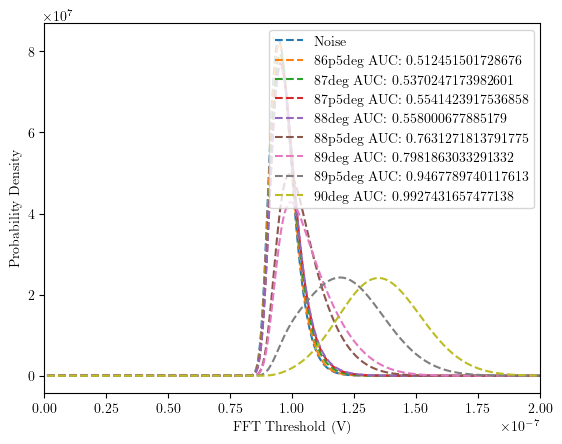

In [387]:
noise_cdf, noise_pdf = get_dists([], x, tau_1f, Nsamp)

def get_roc(noise_cdf, signal_cdf):
    fpr = 1 - noise_cdf
    tpr = 1 - signal_cdf
    
    return fpr, tpr

    
plt.plot(x, noise_pdf, label='Noise', linestyle='--')


for filename in file_list:
    
    signal = get_signal(filename, 'signal1') # One polarisation

    pks = get_signal_peaks(signal, 1e-9)
    cdf, pdf = get_dists(pks, x, tau_1f, Nsamp)
    
    fpr,tpr = get_roc(noise_cdf, cdf)
    auc = abs(np.trapz(tpr, fpr))
    
    
    label = filename.split('/')[1].split('.')[0] + ' AUC: ' + str(auc)
    
    # plt.text(0.1e-6, 0.1e6, str(label) + ' AUC: ' + str(auc))

    
    plt.plot(x, pdf, label=label, linestyle='--')

    plt.xlim(0, 0.2e-6)

plt.xlabel('FFT Threshold (V)')
plt.ylabel('Probability Density')

plt.legend()

plt.savefig('harmonic_dists.png')

plt.show(  )

The next code cell is the bedrock of the analysis. Here we gather all the truth/false positive rates for each pitch angle. We then calculate the mean and standard deviation of these values and plot them on the ROC curve.

In [289]:
# filecontainer is a list of lists, each list contains the filenames for a specific angle
# we need a directory for each angle


def get_auc_eff(filelist, override_path=False):
    def get_efficiency(tpr, fpr, threshold):
        """Helper function to compute efficiency for a given FPR threshold."""
        ind = np.where(fpr < threshold)[0][0]
        return tpr[ind]
    


    degrees, aucs, fpr_vals, tpr_vals = [], [], [], []
    efficiencies = {0.1: [], 0.05: [], 0.01: []}

    for filename in filelist:
        signal = get_signal(filename, 'signal1', full_path=False, override_path=override_path)  # One polarisation
        pks = get_signal_peaks(signal, 1e-9)
        cdf, pdf = get_dists(pks, x, tau_1f, Nsamp)

        fpr, tpr = get_roc(noise_cdf, cdf)
        aucs.append(abs(np.trapz(tpr, fpr)))
        fpr_vals.append(np.array([fpr]))
        tpr_vals.append(np.array([tpr]))

        for threshold in efficiencies:
            efficiencies[threshold].append(get_efficiency(tpr, fpr, threshold))

        degrees.append(override_path.split('/')[-2])

    return degrees, aucs, efficiencies[0.1], efficiencies[0.05], efficiencies[0.01], fpr_vals, tpr_vals

angle_dir = ['86.5deg', '87.0deg', '87.5deg', '88.0deg', '88.5deg', '89.0deg', '89.5deg', '90.0deg']

degrees = []
aucs = []
efficiencies10 = []
efficiencies5 = []
efficiencies1 = []
fpr_values = []
tpr_values = []


# files_container_test = files_container[:2]


for i in range(len(files_container)):

    override_path = '../../../../Desktop/v2/Harmonic/' + angle_dir[i] + '/'


    degrees_temp, aucs_temp, efficiencies10_temp, efficiencies5_temp, efficiencies1_temp, fpr_vals, tpr_vals = get_auc_eff(files_container[i], override_path=override_path)
    
    degrees.append(degrees_temp)
    aucs.append(aucs_temp)
    efficiencies10.append(efficiencies10_temp)
    efficiencies5.append(efficiencies5_temp)
    efficiencies1.append(efficiencies1_temp)
    fpr_values.append(fpr_vals)
    tpr_values.append(tpr_vals)


In [393]:
# pd.DataFrame(degrees).to_csv('../data/analysis/degrees.csv')
# np.savetxt('../data/analysis/aucs.csv', aucs, delimiter=',')
# np.savetxt('../data/analysis/efficiencies10.csv', efficiencies10, delimiter=',')
# np.savetxt('../data/analysis/efficiencies5.csv', efficiencies5, delimiter=',')
# np.savetxt('../data/analysis/efficiencies1.csv', efficiencies1, delimiter=',')
# np.save('../data/analysis/fpr_values.npy', fpr_values)
# np.save('../data/analysis/tpr_values.npy', tpr_values)

# degrees = np.loadtxt('../data/analysis/degrees.csv', delimiter=',')
degrees = pd.read_csv('../data/analysis/degrees.csv')
degrees = degrees.drop(columns='Unnamed: 0')




aucs = np.loadtxt('../data/analysis/aucs.csv', delimiter=',')
efficiencies10 = np.loadtxt('../data/analysis/efficiencies10.csv', delimiter=',')
efficiencies5 = np.loadtxt('../data/analysis/efficiencies5.csv', delimiter=',')
efficiencies1 = np.loadtxt('../data/analysis/efficiencies1.csv', delimiter=',')
fpr_values = np.load('../data/analysis/fpr_values.npy')
tpr_values = np.load('../data/analysis/tpr_values.npy')

#




# pd.DataFrame(aucs).to_csv('../data/analysis/aucs.csv')
# pd.DataFrame(efficiencies10).to_csv('../data/analysis/efficiencies10.csv')
# pd.DataFrame(efficiencies5).to_csv('../data/analysis/efficiencies5.csv')
# pd.DataFrame(efficiencies1).to_csv('../data/analysis/efficiencies1.csv')
# pd.DataFrame(fpr_values).to_csv('../data/analysis/fpr_values.csv')
# pd.DataFrame(tpr_values).to_csv('../data/analysis/tpr_values.csv')

# aucs = pd.read_csv('../data/analysis/aucs.csv')
# efficiencies10 = pd.read_csv('../data/analysis/efficiencies10.csv')
# efficiencies5 = pd.read_csv('../data/analysis/efficiencies5.csv')
# efficiencies1 = pd.read_csv('../data/analysis/efficiencies1.csv')
# fpr_values = pd.read_csv('../data/analysis/fpr_values.csv')
# tpr_values = pd.read_csv('../data/analysis/tpr_values.csv')

# aucs = aucs.drop(columns='Unnamed: 0')
# efficiencies10 = efficiencies10.drop(columns='Unnamed: 0')
# efficiencies5 = efficiencies5.drop(columns='Unnamed: 0')
# efficiencies1 = efficiencies1.drop(columns='Unnamed: 0')
# fpr_values = fpr_values.drop(columns='Unnamed: 0')
# tpr_values = tpr_values.drop(columns='Unnamed: 0')

# efficiencies10 = np.array(efficiencies10)
# efficiencies5 = np.array(efficiencies5)
# efficiencies1 = np.array(efficiencies1)
# aucs = np.array(aucs)
# fpr_values = np.array(fpr_values)
# tpr_values = np.array(tpr_values)


We can see the events distributed below.

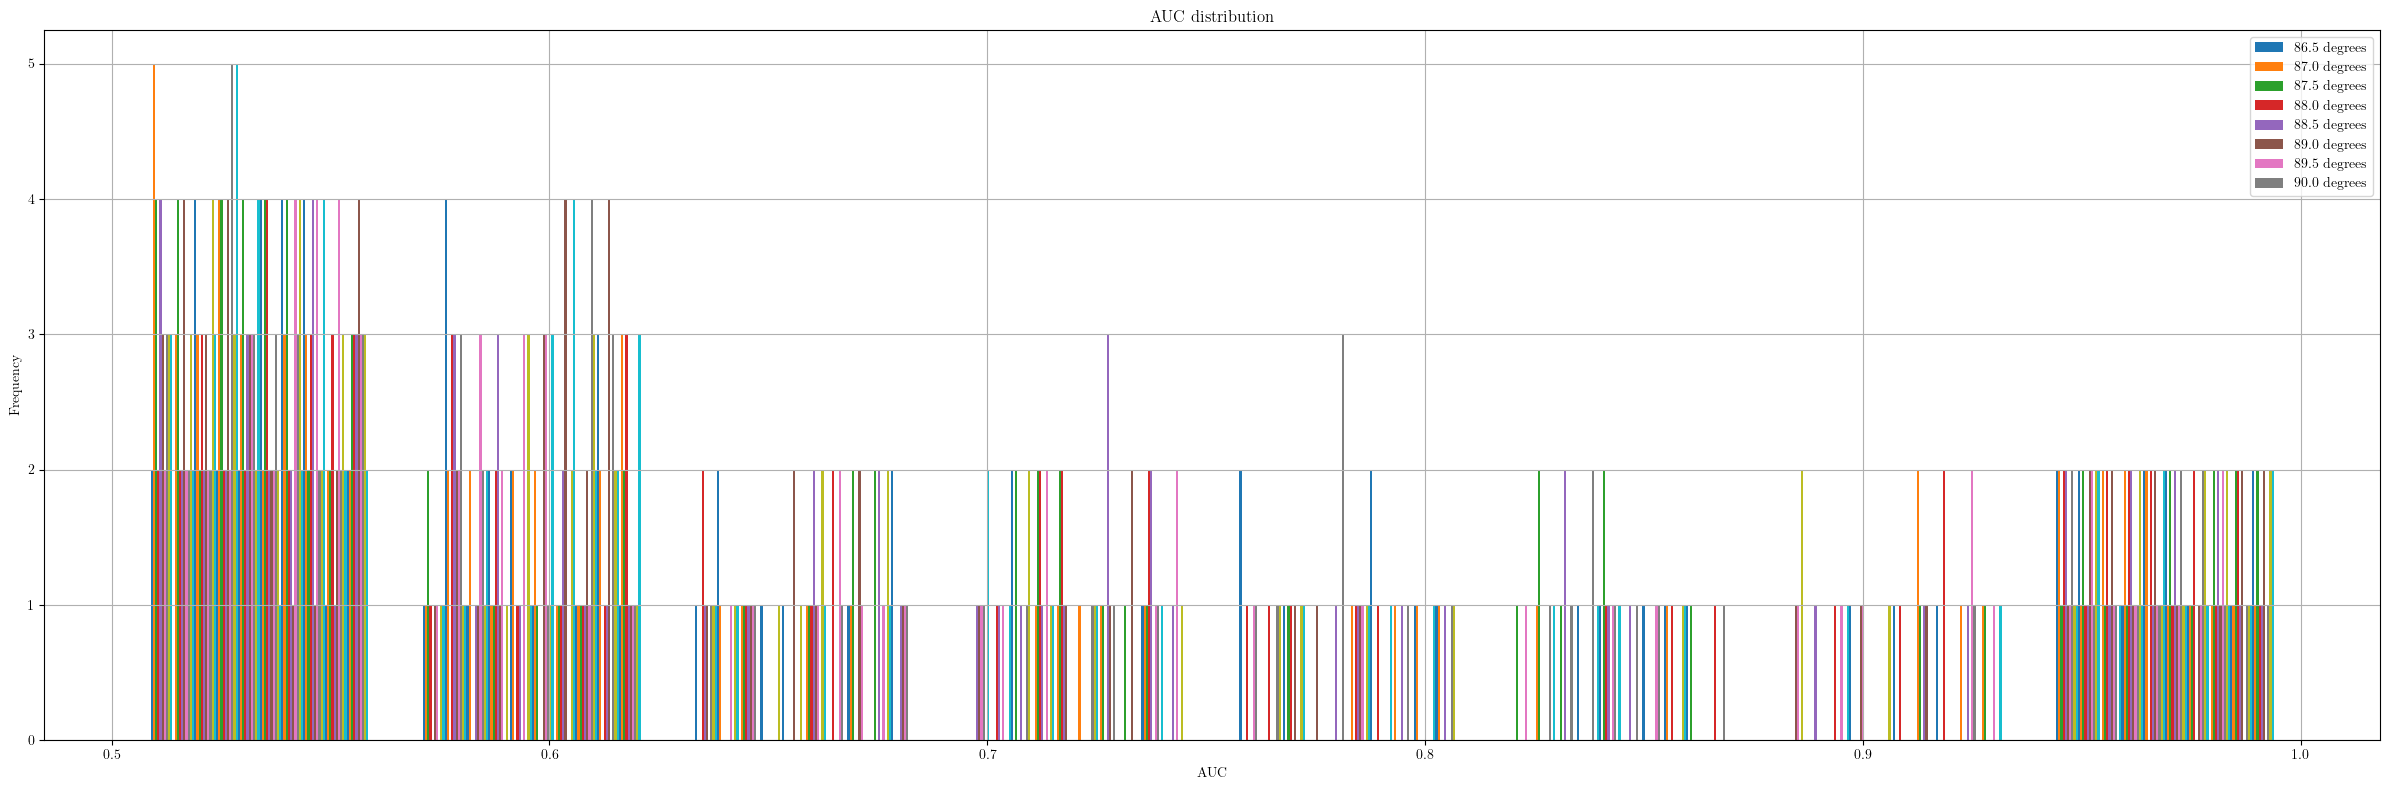

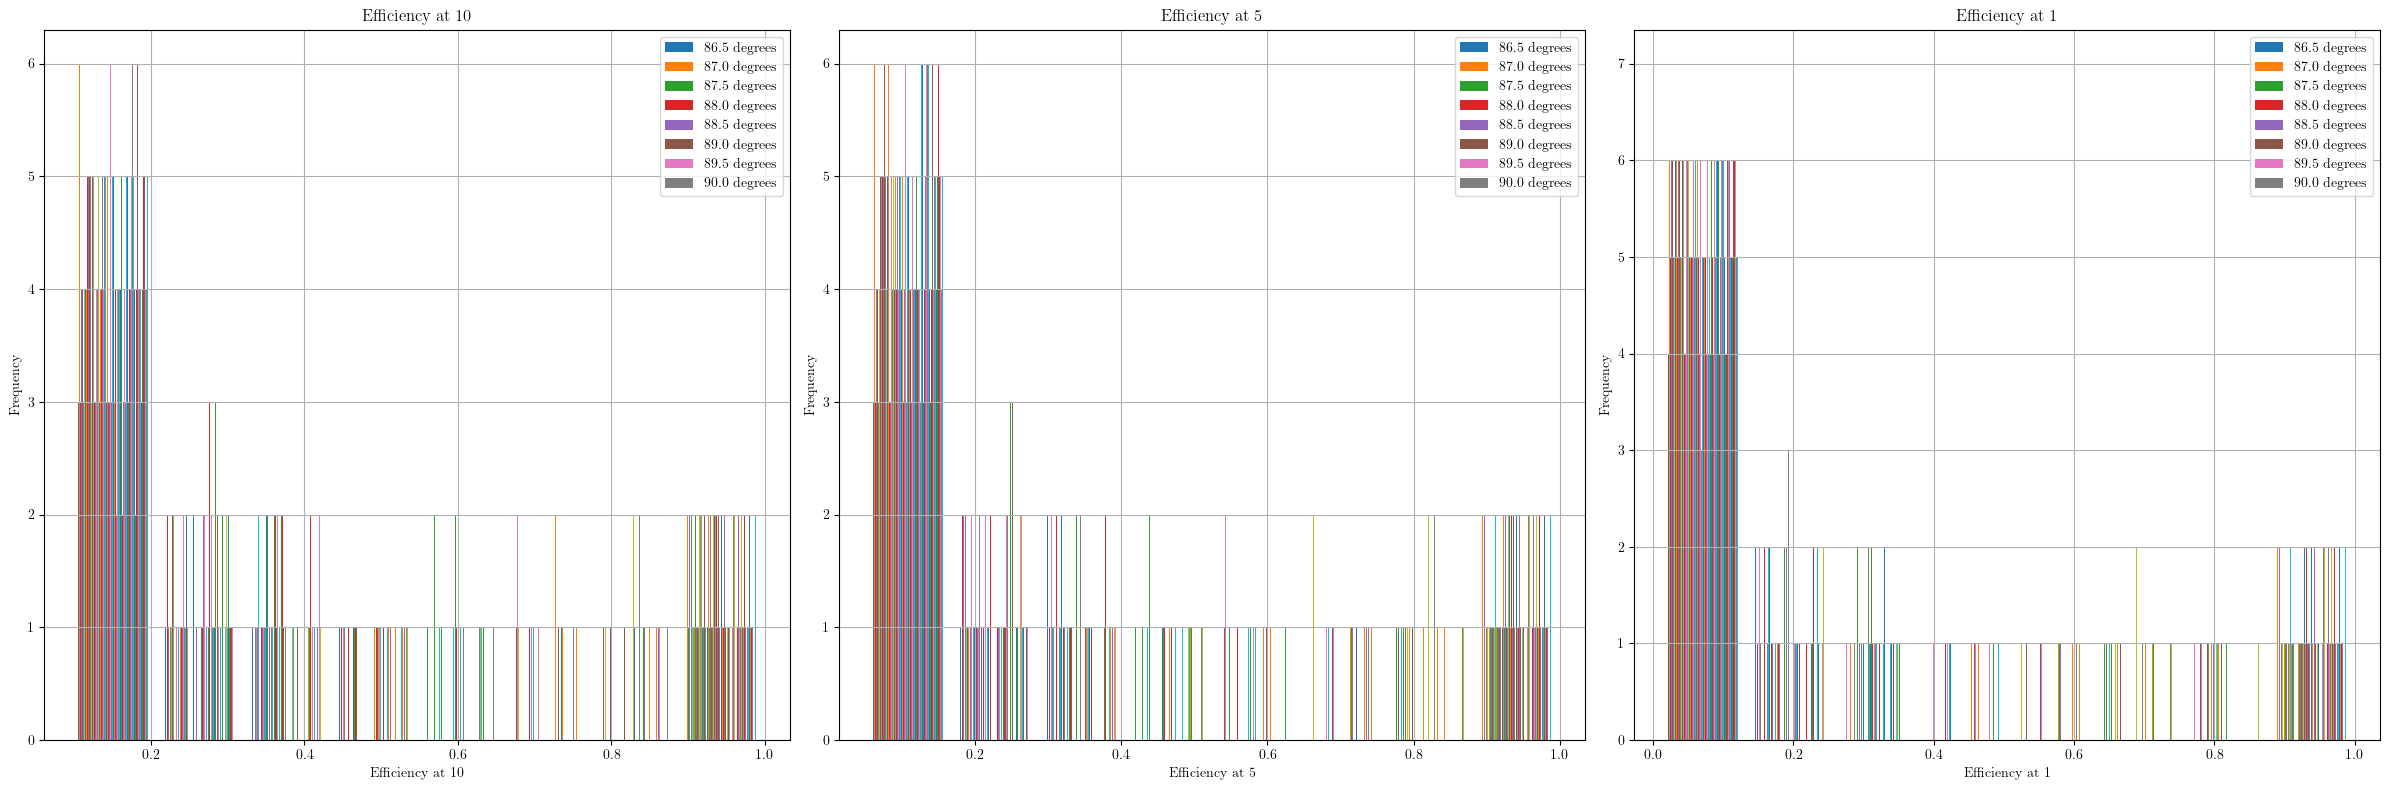

In [302]:
# plotting for 90 degree electrons 

labels = [str(degree) + ' degrees' for degree in df['Pitch angle [degrees]'].unique()]


fig, ax1 = plt.subplots(1, 1, figsize=(24, 8))


ax1.hist(aucs, bins=8)
ax1.set_xlabel('AUC')
ax1.set_ylabel('Frequency')
ax1.set_title('AUC distribution')

ax1.legend(labels)


plt.tight_layout()
plt.grid(True)

plt.savefig('../figures/harmonic_auc.png')
plt.show()


fig, ax1 = plt.subplots(1, 3, figsize=(24, 8))


ax1[0].hist(efficiencies10, bins=8)
ax1[0].set_xlabel('Efficiency at 10% FPR')
ax1[0].set_ylabel('Frequency')
ax1[0].set_title('Efficiency at 10% FPR distribution')
ax1[0].grid(True)

ax1[1].hist(efficiencies5, bins=8)
ax1[1].set_xlabel('Efficiency at 5% FPR')
ax1[1].set_ylabel('Frequency')
ax1[1].set_title('Efficiency at 5% FPR distribution')
ax1[1].grid(True)

ax1[2].hist(efficiencies1, bins=8)
ax1[2].set_xlabel('Efficiency at 1% FPR')
ax1[2].set_ylabel('Frequency')
ax1[2].set_title('Efficiency at 1% FPR distribution')
ax1[2].grid(True)

# create labels for a legend 

ax1[0].legend(labels)
ax1[1].legend(labels)
ax1[2].legend(labels)

plt.tight_layout()

plt.savefig('../figures/harmonic_efficiencies.png')

plt.show()



In [394]:
# Pull out the radii for each event from the data frame and store them 
import re

radii_magnitude_container = []

for i in range(len(files_container)):
    radii = []
    for filename in files_container[i]:

        rad_x = df.loc[df['File_name'] == filename]['Starting x position [metres]']
        rad_y = df.loc[df['File_name'] == filename]['Starting x position [metres]']
        rad_z = df.loc[df['File_name'] == filename]['Starting x position [metres]']

        radius_magnitude = np.linalg.norm([rad_x, rad_y, rad_z])    

        radii.append(radius_magnitude)
    radii_magnitude_container.append(radii)


pd.DataFrame(radii_magnitude_container).to_csv('../data/analysis/radii_magnitudes.csv')



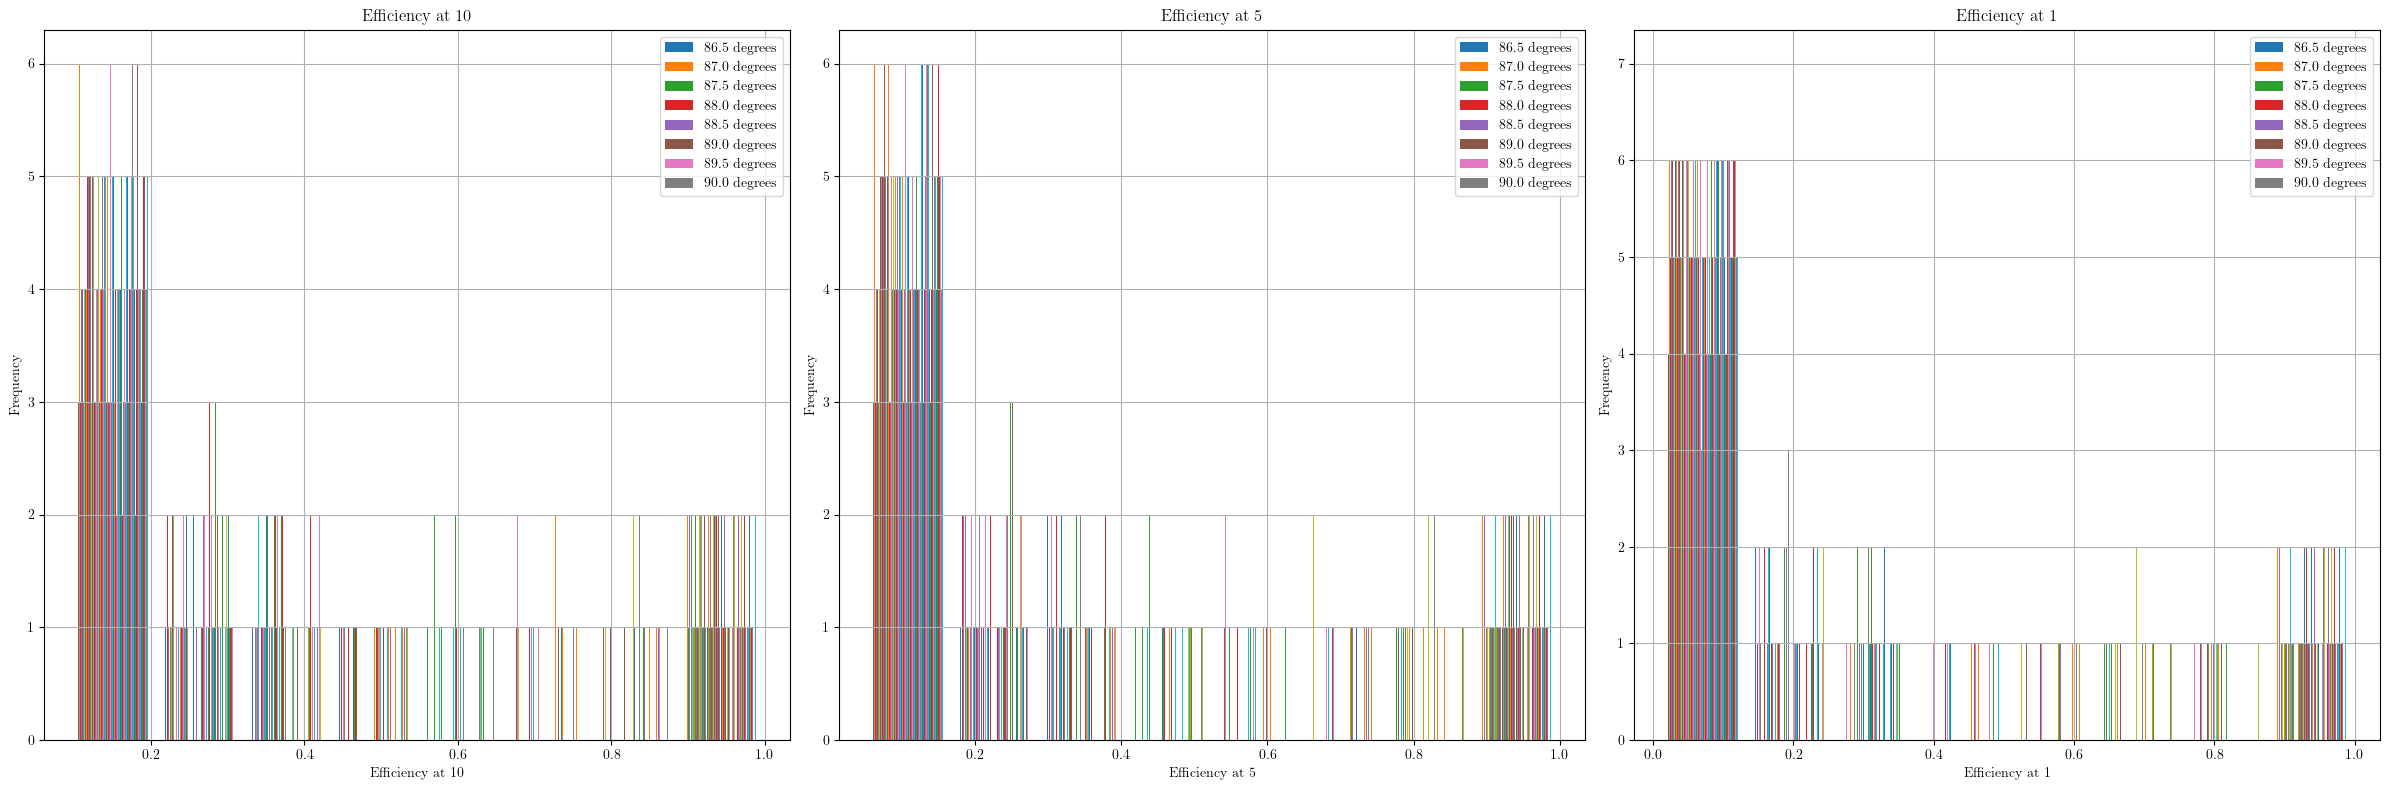

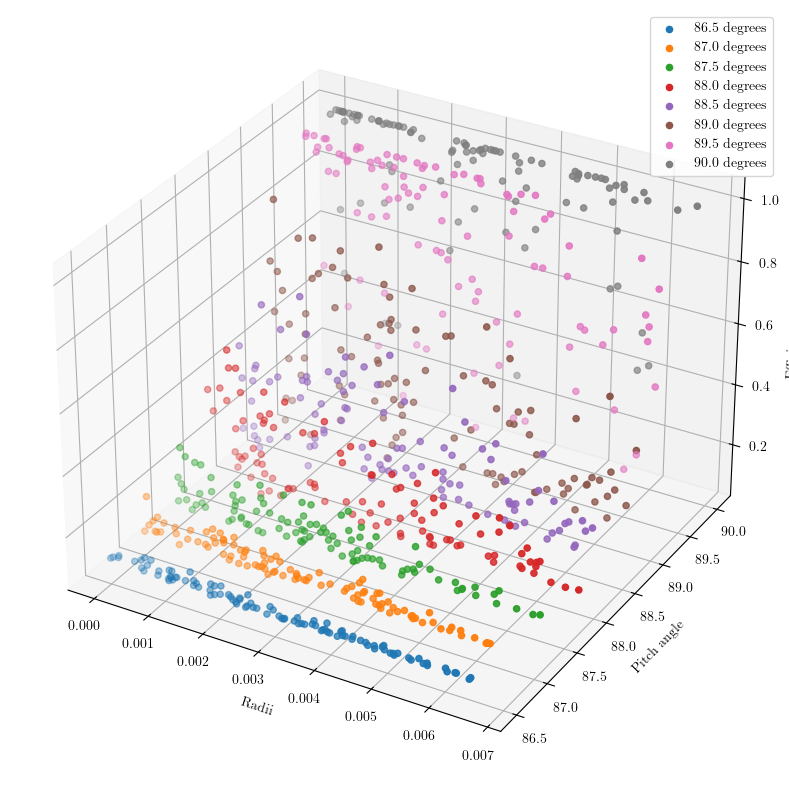

In [395]:

true_angles = df['Pitch angle [degrees]'].values

fig, ax1 = plt.subplots(1, 3, figsize=(24, 8))


ax1[0].hist(efficiencies10, bins=8)
ax1[0].set_xlabel('Efficiency at 10% FPR')
ax1[0].set_ylabel('Frequency')
ax1[0].set_title('Efficiency at 10% FPR distribution')
ax1[0].grid(True)

ax1[1].hist(efficiencies5, bins=8)
ax1[1].set_xlabel('Efficiency at 5% FPR')
ax1[1].set_ylabel('Frequency')
ax1[1].set_title('Efficiency at 5% FPR distribution')
ax1[1].grid(True)

ax1[2].hist(efficiencies1, bins=8)
ax1[2].set_xlabel('Efficiency at 1% FPR')
ax1[2].set_ylabel('Frequency')
ax1[2].set_title('Efficiency at 1% FPR distribution')
ax1[2].grid(True)

# create labels for a legend 

ax1[0].legend(labels)
ax1[1].legend(labels)
ax1[2].legend(labels)

plt.tight_layout()

plt.savefig('../figures/harmonic_efficiencies.png')

plt.show()

# Replicate the above plot but let us plot the radii and pitch angle on a 3d plot and the efficiency will be a Z value or a colour map

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(radii_magnitude_container)):
    ax.scatter(radii_magnitude_container[i], angles[i], efficiencies10[i], label=labels[i])

ax.set_xlabel('Radii')
ax.set_ylabel('Pitch angle')
ax.set_zlabel('Efficiency at 10% FPR')

plt.tight_layout()
plt.legend()

plt.savefig('../figures/harmonic_3d_efficiencies.png')

plt.show()

### Replicate the above plot but do it with plotly so it is interactive

import plotly.express as px

fig = px.scatter_3d(x=np.reshape(radii_magnitude_container, -1), y=true_angles, z=np.reshape(efficiencies10,-1))

fig.show()



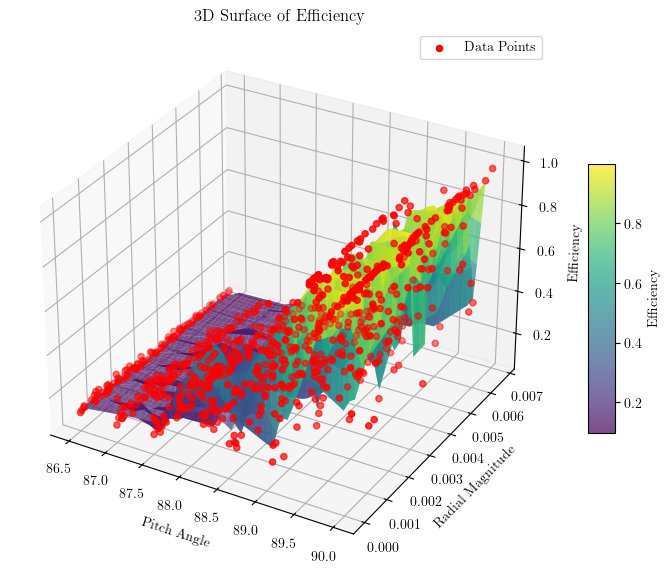

In [305]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# # Example data: Replace these with your actual data
# pitch_angle = np.array([10, 20, 30, 40, 50])  # Example pitch angles
# radial_magnitude = np.array([1, 2, 3, 4, 5])  # Example radial magnitudes
# efficiency = np.array([0.8, 0.85, 0.9, 0.95, 1.0])  # Example efficiencies

# Create a grid for interpolation
xi = np.linspace(min(true_angles), max(true_angles), 50)  # Fine grid for pitch angle
yi = np.linspace(min(np.reshape(radii_magnitude_container,-1)), max(np.reshape(radii_magnitude_container,-1)), 50)  # Fine grid for radial magnitude
xi, yi = np.meshgrid(xi, yi)

# Interpolate data
zi = griddata((true_angles, np.reshape(radii_magnitude_container,-1)), np.reshape(efficiencies10,-1), (xi, yi), method='linear')

# Plot the scatter and the surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the original data
ax.scatter(true_angles, radii_magnitude_container, efficiencies10, color='red', label='Data Points')

# Surface plot of the interpolated data
surf = ax.plot_surface(xi, yi, zi, cmap='viridis', alpha=0.7, edgecolor='none')

# Add labels
ax.set_xlabel('Pitch Angle')
ax.set_ylabel('Radial Magnitude')
ax.set_zlabel('Efficiency')
ax.set_title('3D Surface of Efficiency')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Efficiency')

plt.legend()
plt.show()


Interactive 3D plot of efficiency for all events. (Must run the code cell below to see the plot)

In [306]:
import numpy as np
import plotly.graph_objects as go
from scipy.interpolate import griddata


# Create the 3D surface
surface = go.Surface(
    x=xi, 
    y=yi, 
    z=zi, 
    colorscale='Viridis', 
    colorbar=dict(title='Efficiency')
)

# Create the scatter points
scatter = go.Scatter3d(
    x=true_angles, 
    y=radii_magnitude_container, 
    z=efficiencies10, 
    mode='markers', 
    marker=dict(size=5, color='red'),
    name='Data Points'
)

# Combine and plot
fig = go.Figure(data=[surface, scatter])
fig.update_layout(
    scene=dict(
        xaxis_title='Pitch Angle',
        yaxis_title='Radial Magnitude',
        zaxis_title='Efficiency'
    ),
    title='Interactive 3D Surface and Scatter Plot',
    width=1200,  # Set the figure width
    height=600   # Set the figure height
)

fig.show()

In [397]:
# Distribution of radial magnitudes for each pitch angle

# fig, ax = plt.subplots(2, 4, figsize=(16, 8))
# plt.title('Average ROC curve for each pitch angle')

# for i in range(len(radii_magnitude_container)):
    
#     ax[i//4, i%4].hist(radii_magnitude_container[i], bins=100, label=labels[i])
#     ax[i//4, i%4].legend()
#     ax[i//4, i%4].grid(True)
# plt.tight_layout()
# plt.show()

ROC Curves +/ One sigma and Two Sigma bands are plotted for each pitch angle.

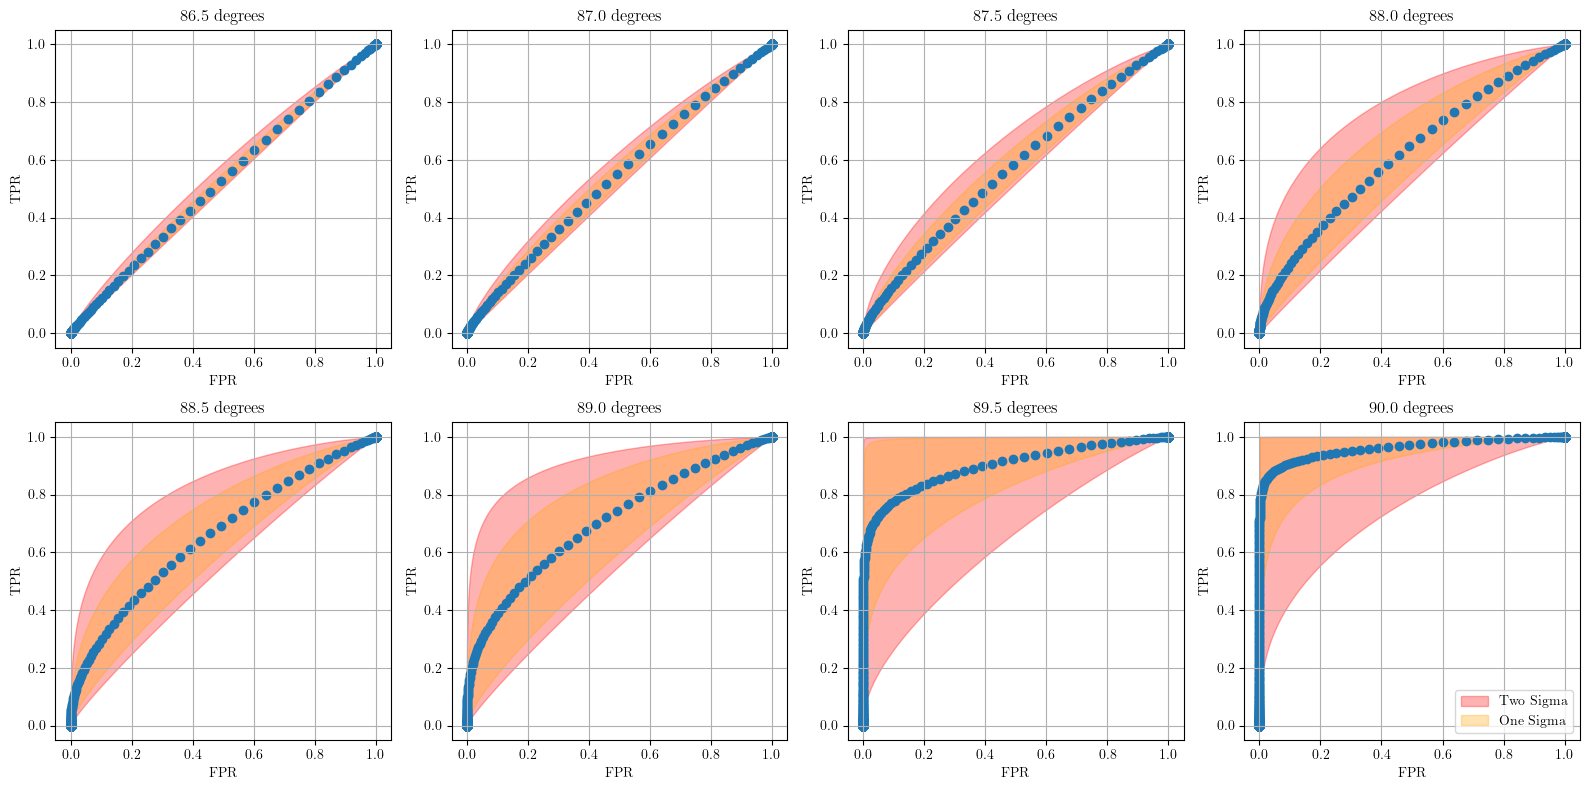

In [398]:

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
plt.title('Average ROC curve for each pitch angle')

for i in range(len(radii_magnitude_container)):
    

    hep_curves = zip(fpr_values[i], tpr_values[i], aucs[i])

    sorted_hep_curves = sorted(hep_curves, key=lambda x: x[2])

    sorted_fpr, sorted_tpr, sorted_auc = zip(*sorted_hep_curves)

    ax[i//4, i%4].fill_between(sorted_fpr[0][0], sorted_tpr[3][0], sorted_tpr[-3][0], alpha=0.3, color='red', label='Two Sigma')
    ax[i//4, i%4].fill_between(sorted_fpr[0][0], sorted_tpr[16][0], sorted_tpr[-16][0], alpha=0.3, color='orange', label='One Sigma')
    ax[i//4, i%4].scatter(np.mean(sorted_fpr, axis=0), np.mean(sorted_tpr, axis=0))
    ax[i//4, i%4].set_title(labels[i])
    ax[i//4, i%4].set_xlabel('FPR')
    ax[i//4, i%4].set_ylabel('TPR')
    ax[i//4, i%4].grid(True)

    if i == 7:
        ax[i//4, i%4].legend()

plt.tight_layout()
plt.show()

### Archive 


Example of using more peaks to influence the PDF generation. Using the maximimum peak vs using multiple peaks. 

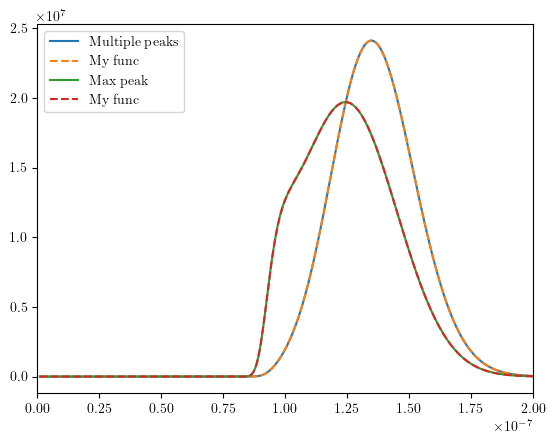

In [386]:
pks = get_signal_peaks(signal, 5e-8)

signal_pdf, signal_cdf = calculate_signal_dists(threshold, tau_1f, 0, pks, Nsamp)


rice_cdf = np.ones(20001)
for peak in pks:
    rice_cdf *= scipy.stats.rice.cdf(x, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
    
signal_cdf = rice_cdf * (1-np.exp(-(x**2)/tau_1f)) ** (Nsamp-pks.size)

signal_pdf = np.gradient(signal_cdf, x[1]-x[0])

plt.plot(x, signal_pdf, label='Multiple peaks')

cdf, pdf = get_dists(pks, x, tau_1f, Nsamp)

plt.plot(x, pdf, label='My func', linestyle='--')


rice_cdf = np.ones(20001)
rice_cdf *= scipy.stats.rice.cdf(x, b=abs(np.max(pks))/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
signal_cdf = rice_cdf * (1-np.exp(-(x**2)/tau_1f)) ** (Nsamp-pks.size)
signal_pdf = np.gradient(signal_cdf, x[1]-x[0])

plt.plot(x, signal_pdf, label='Max peak')

cdf, pdf = get_dists(np.array([abs(np.max(pks))]), x, tau_1f, Nsamp)

plt.plot(x, pdf, label='My func', linestyle='--')

plt.xlim(0, 0.2e-6)
plt.legend();